# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want to be able to say "the error of the model at predicting tree cover was x +/- y at the 95% confidence level". When we report on numbers we will directly reference these confidence intervals.

## Steps
- Start with biomes because they will have tight error bars
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Create visualizations to see the error bars (heatmap? examples [here?](https://clauswilke.com/dataviz/visualizing-uncertainty.html))

## Key Questions
- How granular can we make these validation assessments for each region/subregion/ecoregion? 
- Confidence intervals: How confident are we that a certain range around these estimates of tree cover actually contains the true parameter?
- What do the error bars look like for precision, recall and percent error? 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [151]:
df = pd.read_csv('validation_data_1000.csv')
df2 = pd.read_csv("eval-numbers-lulc.csv")

In [152]:
df.head(5)

,plot_id,tree_class,country,region,subregion,ecoregion,biome
0,139270540,None (0%),Ethiopia,Africa,Eastern Africa,Ethiopian Xeric Grasslands And Shrublands,Deserts and Xeric Shrublands
1,139191077,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
2,139270113,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
3,139270158,None (0%),Botswana,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands
4,139270154,None (0%),Namibia,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands


In [153]:
df2.head(5)

,field_1,plot_id,lat,long,y,error,tp,fp,fn,tree_cover,saafricalul,LULC
0,20,139190101,21.585058,-98.412462,58,-8,58,0,0,29,10,Cropland
1,21,139190102,21.805647,-98.133049,58,-4,58,0,0,29,10,Cropland
2,32,139190117,18.232098,-95.735977,3,-3,2,2,1,1,10,Cropland
3,33,139190118,17.673272,-94.809501,57,9,51,0,6,29,10,Cropland
4,35,139190120,18.085039,-95.133032,58,6,49,0,9,29,10,Cropland


In [154]:
df = pd.merge(df, df2, on = 'plot_id')

## Quick EDA

In [72]:
#df = pd.read_csv('validation_data_1000.csv')
#df.head()

,plot_id,tree_class,country,region,subregion,ecoregion,biome
0,139270540,None (0%),Ethiopia,Africa,Eastern Africa,Ethiopian Xeric Grasslands And Shrublands,Deserts and Xeric Shrublands
1,139191077,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
2,139270113,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
3,139270158,None (0%),Botswana,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands
4,139270154,None (0%),Namibia,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands


In [155]:
df['pred'] = df.tp + df.fp
df['true'] = df.tp + df.fn

In [156]:
df.groupby('LULC')['tp'].sum() / (df.groupby('LULC')['fp'].sum() + df.groupby('LULC')['tp'].sum())

LULC
Bare                  0.000000
Cropland              0.949952
Forest                0.994220
Grassland             0.943814
Mosaic cropland       0.973106
Mosaic forest         0.953616
Mosaic grassland      0.957861
Mosaic natural veg    0.970073
Shrubland             0.961169
Sparse veg            0.975124
Urban                 0.947883
Wetland               0.333333
dtype: float64

In [157]:
df.groupby('LULC')['pred'].sum() / df.groupby('LULC')['true'].sum()

LULC
Bare                  1.000000
Cropland              0.995011
Forest                1.001946
Grassland             0.984697
Mosaic cropland       0.998432
Mosaic forest         0.998009
Mosaic grassland      0.981702
Mosaic natural veg    0.969340
Shrubland             1.005636
Sparse veg            0.954869
Urban                 0.959375
Wetland               2.571429
dtype: float64

In [158]:
df.groupby('tree_class')['pred'].sum() / df.groupby('tree_class')['true'].sum()

tree_class
Dense (75+%)             0.999496
Medium-dense (40-75%)    0.996735
None (0%)                9.925926
Open (10 - 39%)          0.952844
Scattered (1 - 9%)       0.925507
dtype: float64

In [159]:
df.subregion.value_counts()

South America      318
Eastern Africa     175
Central America    136
Western Africa     104
Northern Africa     70
Southern Africa     69
Middle Africa       65
Caribbean           30
Name: subregion, dtype: int64

In [160]:
df.biome.value_counts()

Tropical and Subtropical Grasslands, Savannas and Shrublands    357
Tropical and Subtropical Moist Broadleaf Forests                237
Tropical and Subtropical Dry Broadleaf Forests                   95
Deserts and Xeric Shrublands                                     66
Montane Grasslands and Shrublands                                50
Mediterranean Forests, Woodlands and Scrub                       47
Temperate Grasslands, Savannas and Shrublands                    37
Tropical and Subtropical Coniferous Forests                      29
Temperate Broadleaf and Mixed Forests                            24
Flooded Grasslands and Savannas                                  21
Mangroves                                                         3
Name: biome, dtype: int64

In [161]:
df.tree_class.value_counts(normalize=True)*100

None (0%)                36.918304
Scattered (1 - 9%)       21.923475
Dense (75+%)             19.338159
Open (10 - 39%)          15.822130
Medium-dense (40-75%)     5.997932
Name: tree_class, dtype: float64

In [162]:
df.head()

,plot_id,tree_class,country,region,subregion,ecoregion,biome,field_1,lat,long,y,error,tp,fp,fn,tree_cover,saafricalul,LULC,pred,true
0,139270540,None (0%),Ethiopia,Africa,Eastern Africa,Ethiopian Xeric Grasslands And Shrublands,Deserts and Xeric Shrublands,965,11.474302,41.516966,0,0,0,0,0,0,120,Shrubland,0,0
1,139191077,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands,501,6.100608,48.748936,0,0,0,0,0,0,152,Sparse veg,0,0
2,139270113,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands,805,4.039354,47.390776,1,0,0,0,1,0,152,Sparse veg,0,1
3,139270158,None (0%),Botswana,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands,824,-25.529835,25.238610,0,-1,0,1,0,0,11,Cropland,1,0
4,139270154,None (0%),Namibia,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands,821,-22.629077,19.624957,1,-1,1,0,0,0,110,Mosaic grassland,1,1


## Bootstrap from each scale, calculate scores and confidence intervals

In [163]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a scale, 
    calculates scores, then takes percentiles of the bootstrap 
    to calculate confidence intervals and returns 2 dfs with results.
    '''

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        tp = np.sum(tp)
        fp = np.sum(fp)
        fn = np.sum(fn)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        oe = (tp + fp) / (tp + fn)
        return precision, recall, f1, oe
    
    # get a list of categories within the scale
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
                     
    # empty df to store samples, scores and CIs
    bootsamples = pd.DataFrame()
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1', 'oe'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80',
                                       'oe_lower_80', 'oe_upper_80', 'oe_lower_95',
                                      'oe_upper_95'])

    
    # for each category in scale, calculate scores
    for i in categories:
        grouped = df[df[scale] == i]
        
        for num in range(n):   
            bootstrap = grouped.sample(len(grouped), replace = True)
            #bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1, oe = calculate_metrics(sum(bootstrap.tp.values), 
                                                      sum(bootstrap.fp.values), 
                                                      sum(bootstrap.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1,
                                   'oe': oe}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95, oe_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5),\
                                              np.percentile(grouped2.oe.values, 2.5)
                                                    
        
        p_upper_95, r_upper_95, f1_upper_95, oe_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5),\
                                                           np.percentile(grouped2.oe.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90, oe_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5),\
                                                           np.percentile(grouped2.oe.values, 5,) 
                                                            
        p_upper_90, r_upper_90, f1_upper_90, oe_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95),\
                                                           np.percentile(grouped2.oe.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80, oe_lower_90 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10),\
                                                           np.percentile(grouped2.oe.values, 10) 
                                                            
        p_upper_80, r_upper_80, f1_upper_80, oe_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90),\
                                                           np.percentile(grouped2.oe.values, 90)
        
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80,
                                   'oe_upper_95': oe_upper_95,
                                   'oe_lower_95': oe_lower_95}, ignore_index = True)

    # returns scores and conf intervals separately
    return val_df, conf_int

In [164]:
lc_val, lc_conf = bootstrap(df, 'LULC', 200)

LULC has 12 subcategories. 2400 samples in total.


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in long_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [165]:
lc_conf

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,...,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80,oe_lower_80,oe_upper_80,oe_lower_95,oe_upper_95
0,LULC,Cropland,0.923613,0.963553,0.928166,0.957607,0.931277,0.957154,0.932044,0.962362,...,0.935968,0.960194,0.934416,0.953218,0.934833,0.955436,NaN,NaN,0.976265,1.016705
1,LULC,Mosaic cropland,0.954202,0.984586,0.949557,0.984668,0.955897,0.982904,0.956980,0.983921,...,0.961104,0.981935,0.957960,0.981748,0.961607,0.980220,NaN,NaN,0.976884,1.017904
2,LULC,Mosaic grassland,0.895620,0.983344,0.848884,0.985516,0.873759,0.977959,0.902931,0.979358,...,0.918955,0.976910,0.879152,0.974589,0.907578,0.972078,NaN,NaN,0.906427,1.040248
3,LULC,Sparse veg,NaN,NaN,0.572830,0.983969,NaN,NaN,NaN,NaN,...,NaN,NaN,0.807877,0.974373,NaN,NaN,NaN,NaN,0.583333,1.019285
4,LULC,Mosaic natural veg,0.948106,0.983364,0.905370,0.963895,0.928975,0.971110,0.953387,0.981646,...,0.958014,0.979765,0.921866,0.957107,0.941786,0.966336,NaN,NaN,0.936521,0.995540
5,LULC,Wetland,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,...,0.075897,0.716190,NaN,NaN,NaN,NaN,NaN,NaN,0.833333,inf
6,LULC,Bare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LULC,Urban,0.885526,0.985441,0.813938,0.958637,0.857843,0.963369,0.892848,0.980215,...,0.913177,0.975417,0.838633,0.946671,0.884324,0.954411,NaN,NaN,0.847705,1.027826
8,LULC,Grassland,0.904619,0.970469,0.897228,0.958743,0.907412,0.960904,0.912199,0.966161,...,0.918284,0.964162,0.904816,0.948378,0.914271,0.951942,NaN,NaN,0.954545,1.022352
9,LULC,Shrubland,0.916007,0.984113,0.927345,0.989413,0.928511,0.982443,0.929223,0.982018,...,0.937019,0.978974,0.941865,0.981692,0.941433,0.976157,NaN,NaN,0.959522,1.044561


In [128]:
biome_val, biome_conf = bootstrap(df, 'biome', 200)

biome has 11 subcategories. 2200 samples in total.


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [134]:
subregion_val, subregion_conf = bootstrap(df, 'subregion', 200)

subregion has 8 subcategories. 1600 samples in total.


In [119]:
country_val, country_conf = bootstrap(df, 'country', 100)

country has 72 subcategories. 7200 samples in total.


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


KeyboardInterrupt: 

In [159]:
country_val[country_val.category == 'Ethiopia'].head()

,scale,category,precision,recall,f1
5300,country,Ethiopia,0.977779,0.965862,0.971784
5301,country,Ethiopia,0.977773,0.965838,0.971769
5302,country,Ethiopia,0.977758,0.965834,0.971759
5303,country,Ethiopia,0.977753,0.965814,0.971747
5304,country,Ethiopia,0.977745,0.965785,0.971728


In [160]:
ethiopia = country_conf[country_conf.category == 'Ethiopia']
ethiopia

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,r_lower_90,r_upper_90,f1_lower_90,f1_upper_90,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80
53,country,Ethiopia,0.976849,0.977755,0.964038,0.965824,0.970401,0.971753,0.97687,0.977733,0.964089,0.96577,0.970437,0.971714,0.976926,0.97768,0.964138,0.965685,0.97049,0.971645


In [165]:
country_conf[:10]

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,r_lower_90,r_upper_90,f1_lower_90,f1_upper_90,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80
0,country,Panama,1.000000,1.000000,0.964980,0.978972,0.982178,0.989373,1.000000,1.000000,0.965480,0.975545,0.982437,0.987621,1.000000,1.000000,0.965909,0.975208,0.982659,0.987448
1,country,Rwanda,0.999313,0.999971,0.973978,0.975154,0.986483,0.987406,0.999341,0.999971,0.974028,0.975154,0.986522,0.987406,0.999376,0.999941,0.974091,0.975101,0.986572,0.987365
2,country,Tunisia,0.997272,0.999208,0.973409,0.973920,0.985196,0.986402,0.997342,0.999125,0.973428,0.973898,0.985240,0.986350,0.997402,0.998939,0.973443,0.973849,0.985277,0.986234
3,country,Uganda,0.972815,0.996142,0.963721,0.973183,0.968247,0.984532,0.972994,0.995521,0.964048,0.972674,0.968502,0.983965,0.974377,0.994523,0.964338,0.971694,0.969335,0.982986
4,country,Nigeria,0.969982,0.972347,0.945166,0.962189,0.957405,0.967238,0.970016,0.972316,0.945293,0.961181,0.957510,0.966706,0.970084,0.972289,0.945968,0.959883,0.957874,0.965955
5,country,Benin,0.967992,0.969905,0.941246,0.944776,0.954432,0.957175,0.968043,0.969853,0.941376,0.944670,0.954524,0.957096,0.968143,0.969752,0.941582,0.944495,0.954678,0.956956
6,country,Gabon,0.968032,0.969347,0.941364,0.946074,0.954512,0.957564,0.968077,0.969330,0.941506,0.946014,0.954607,0.957550,0.968266,0.969246,0.941871,0.945725,0.954886,0.957337
7,country,Mauritania,0.969339,0.969635,0.943532,0.946037,0.956405,0.957546,0.969342,0.969620,0.943598,0.946021,0.956432,0.957539,0.969360,0.969613,0.943747,0.945910,0.956505,0.957491
8,country,Zimbabwe,0.960793,0.969334,0.939492,0.943246,0.950038,0.956126,0.961062,0.969117,0.939539,0.943060,0.950149,0.955911,0.961509,0.968617,0.939762,0.942720,0.950552,0.955493
9,country,Honduras,0.960732,0.965321,0.939617,0.945484,0.950057,0.955299,0.960842,0.965270,0.939724,0.945350,0.950168,0.955205,0.961117,0.965115,0.940084,0.945124,0.950484,0.955014


## Visualizations

In [130]:
def visualize_precision(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'lightsteelblue', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'royalblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['p_lower_80'],
                               conf_int_df['p_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Precision Confidence Intervals for {title}');
    
    return None

In [131]:
def visualize_recall(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkseagreen', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'seagreen', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['r_lower_80'],
                               conf_int_df['r_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Recall Confidence Intervals for {title}');
    
    return None

In [132]:
def visualize_f1(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'thistle', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkslateblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_80'],
                               conf_int_df['f1_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'F1 Confidence Intervals for {title}')
    
    return None

### Biome

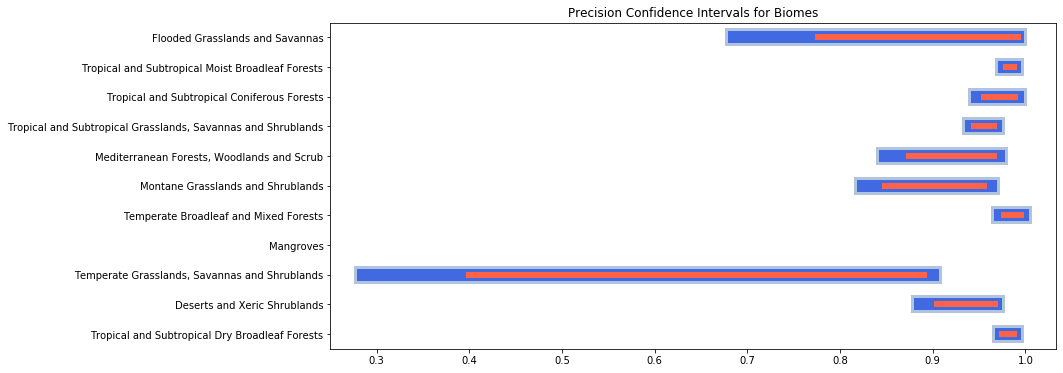

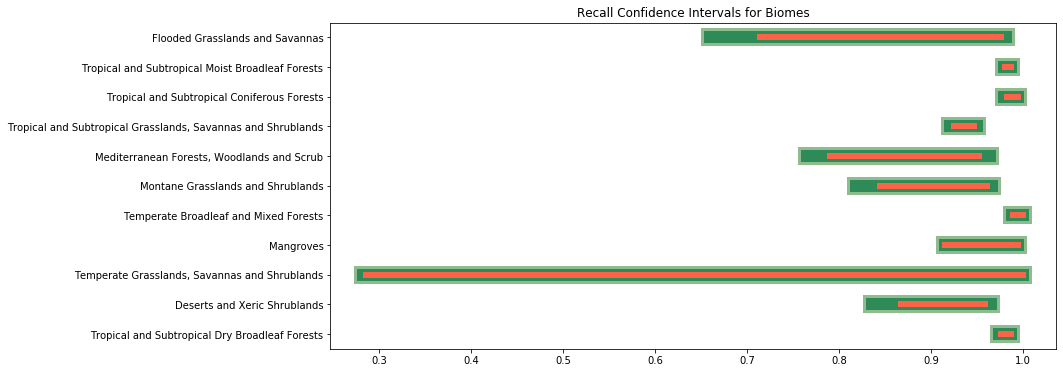

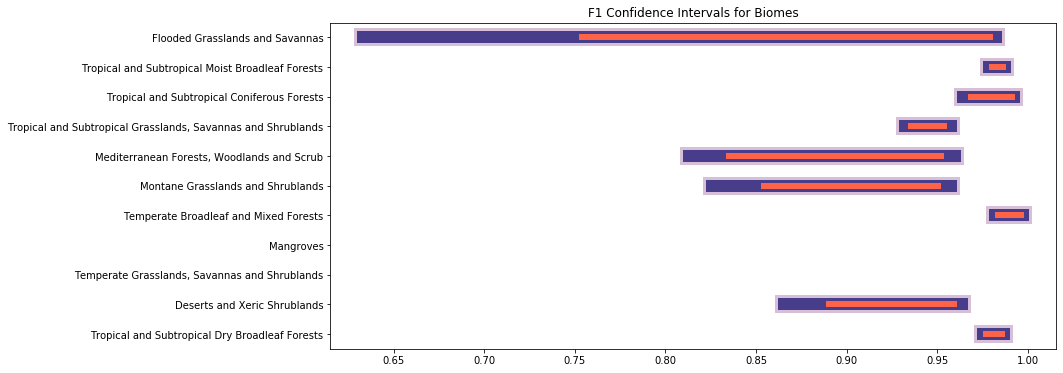

In [133]:
visualize_precision(biome_conf, 6, (13,6), 'Biomes')
visualize_recall(biome_conf, 6, (13,6), 'Biomes')
visualize_f1(biome_conf, 6, (13,6), 'Biomes')

### Subregion

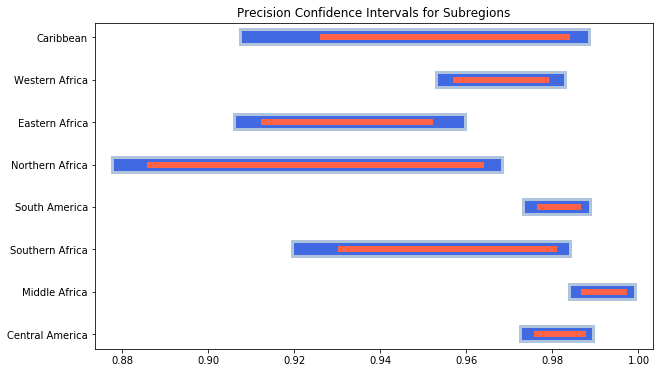

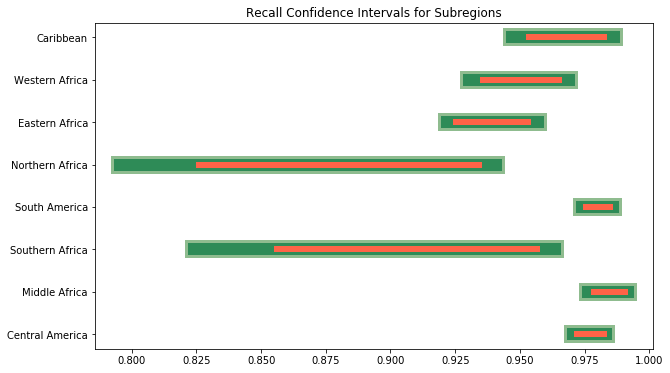

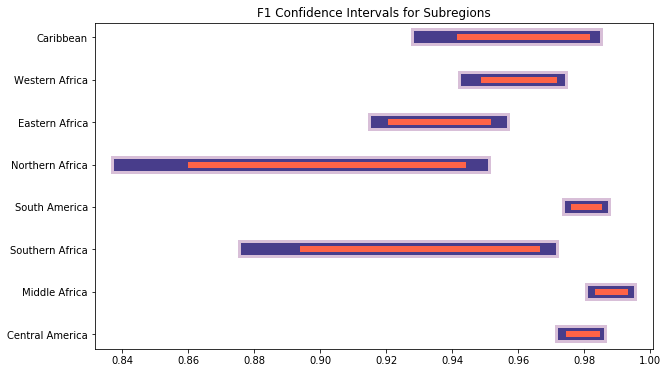

In [135]:
visualize_precision(subregion_conf, 6, (10,6), 'Subregions')
visualize_recall(subregion_conf, 6, (10,6), 'Subregions')
visualize_f1(subregion_conf, 6, (10,6), 'Subregions')

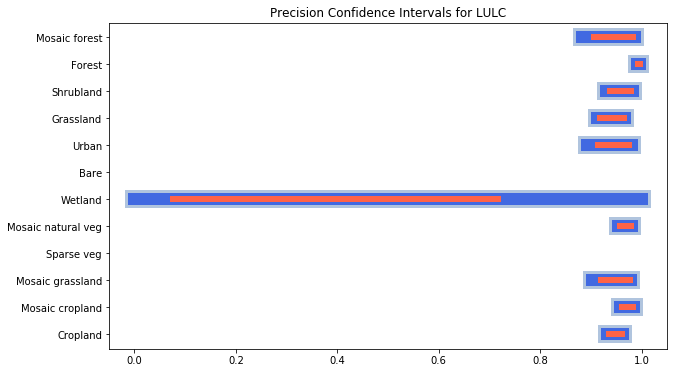

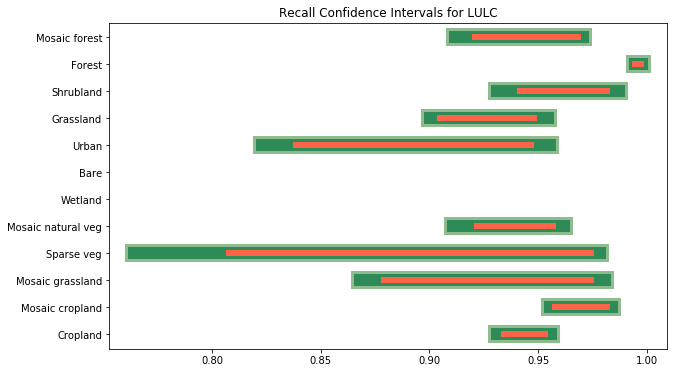

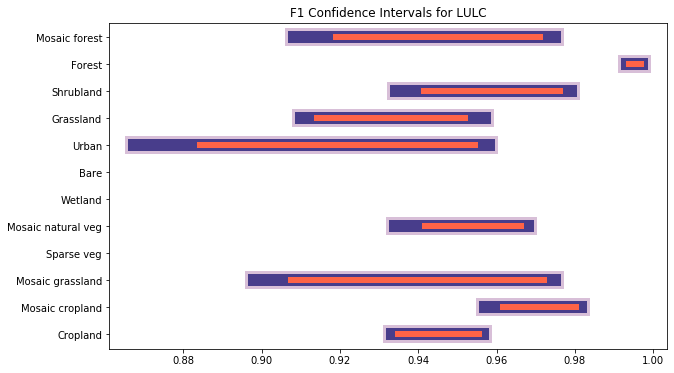

In [166]:
visualize_precision(lc_conf, 6, (10,6), 'LULC')
visualize_recall(lc_conf, 6, (10,6), 'LULC')
visualize_f1(lc_conf, 6, (10,6), 'LULC')

### Country Examples

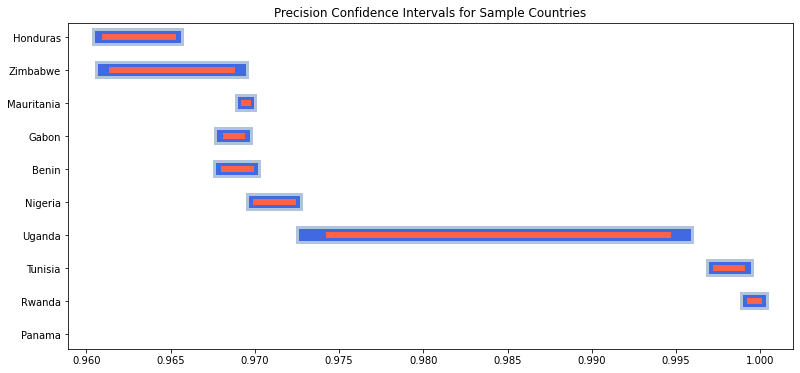

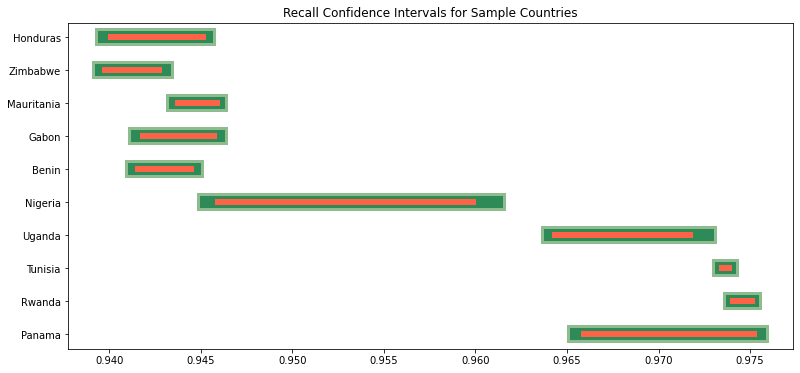

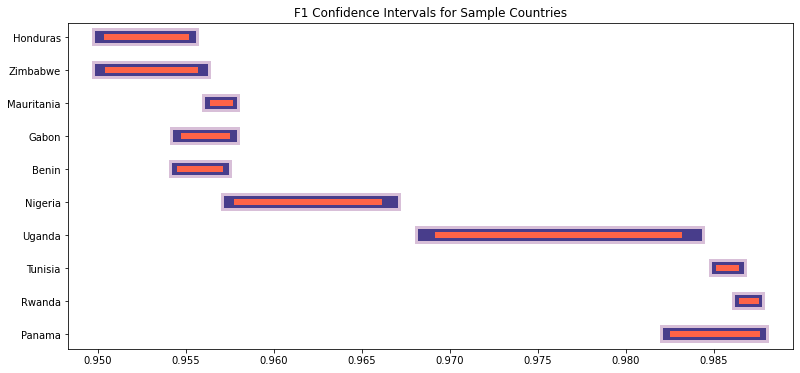

In [168]:
visualize_precision(country_conf[:10], 6, (13,6), 'Sample Countries')
visualize_recall(country_conf[:10], 6, (13,6), 'Sample Countries')
visualize_f1(country_conf[:10], 6, (13,6), 'Sample Countries')